Format: None
Size: (48, 48)
Mode: RGB


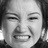

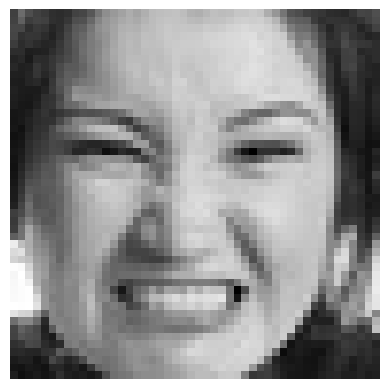

In [12]:
# Cell: load and display a single image
from pathlib import Path
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

# Use relative path from the notebook working directory
img_path = Path(r"train\train\angry_Training_256301.jpg")
img = Image.open(img_path).convert('RGB')

# Print basic info
print("Format:", img.format)
print("Size:", img.size)
print("Mode:", img.mode)

# Display inline in the notebook
display(img)

# Matplotlib alternative for color handling
plt.imshow(img)
plt.axis('off')
plt.show()

In [13]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import torch

# Load model and processor
processor = ViTImageProcessor.from_pretrained('abhilash88/face-emotion-detection')
model = ViTForImageClassification.from_pretrained('abhilash88/face-emotion-detection')

# Load and preprocess image (use Path / raw string to avoid escape sequences)
img_path = Path(r"train\train\angry_Training_143373.jpg")
image = Image.open(img_path).convert('RGB')
inputs = processor(image, return_tensors="pt")


# Make prediction
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(predictions, dim=-1).item()

# Emotion classes
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
predicted_emotion = emotions[predicted_class]
confidence = predictions[0][predicted_class].item()

print(f"Predicted Emotion: {predicted_emotion} ({confidence:.2f})")


Predicted Emotion: Angry (0.99)


In [14]:
# Batch predict all images in the test folder and write submission.csv
from pathlib import Path
from PIL import Image
import torch
import csv
from tqdm.notebook import tqdm

# Adjust this path if your test images are located elsewhere
test_dir = Path('test/test')
output_csv = Path('submission.csv')

# Emotion labels must match the model's label order
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Ensure model and processor are available in the notebook namespace
# If not, uncomment the following two lines to (re)load them:
# from transformers import ViTImageProcessor, ViTForImageClassification
# processor = ViTImageProcessor.from_pretrained('abhilash88/face-emotion-detection')
# model = ViTForImageClassification.from_pretrained('abhilash88/face-emotion-detection')

device = next(model.parameters()).device if any(True for _ in model.parameters()) else 'cpu'
model.to(device)
model.eval()

rows = []

# Collect image files (filter common image extensions)
img_files = sorted([p for p in test_dir.iterdir() if p.suffix.lower() in ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')])

for p in tqdm(img_files, desc='Predicting'):
    try:
        img = Image.open(p).convert('RGB')
    except Exception as e:
        print(f"Failed to open {p}: {e}")
        continue

    # Preprocess and move tensors to model device
    inputs = processor(img, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = int(torch.argmax(probs, dim=-1).item())

    label = emotions[pred_idx].lower()
    rows.append((p.name, label))

# Write CSV in the required format: ID,Category
with output_csv.open('w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['ID', 'Category'])
    writer.writerows(rows)

print(f'Wrote {len(rows)} predictions to {output_csv}')

Predicting:   0%|          | 0/7177 [00:00<?, ?it/s]

Wrote 7177 predictions to submission.csv
